In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calculate_area(contours,image4,file_path):
    # 获取轮廓点集
    contour = contours[-1]

    # 提取横坐标
    x_coordinates = contour[:, 0, 0]

    # 获取最左和最右坐标
    leftmost_x = np.min(x_coordinates)
    rightmost_x = np.max(x_coordinates)
    airfoil_width = rightmost_x-leftmost_x
    
    # 找到最上方和最下方的点
    bottommost_point = tuple(contour[contour[:, :, 1].argmin()][0])
    topmost_point = tuple(contour[contour[:, :, 1].argmax()][0])
    airfoil_height = topmost_point[1]-bottommost_point[1]
    print("leftmost_x,rightmost_x,bottommost_point,topmost_point:",leftmost_x,rightmost_x,bottommost_point,topmost_point)
    image_crop=image4[:,:rightmost_x]
    # 获取图像的高度和宽度
    height, width = image4.shape[:2]


    above_mask = draw_above_mask(image4,file_path,leftmost_x,topmost_point[1],airfoil_width,airfoil_height, width,height)
    above_mask = above_mask[:,:rightmost_x]
    # 将图像转换为HSV颜色空间
    hsv = cv2.cvtColor(image_crop, cv2.COLOR_BGR2HSV)

    # 定义深蓝色范围
    lower_dark_blue = np.array([110, 50, 50])  # 深蓝色下限
    upper_dark_blue = np.array([130, 255, 255])  # 深蓝色上限

    # 创建深蓝色掩码
    dark_blue_mask = cv2.inRange(hsv, lower_dark_blue, upper_dark_blue)
    
        # 创建一个新的图形
    plt.figure()

    # 将图像显示在图形中
    plt.imshow(dark_blue_mask)

    # 显示图形
    plt.show()
    
    print("above_mask.shape, dark_blue_mask.shape",above_mask.shape, dark_blue_mask.shape)
    # 与深蓝色区域的掩膜进行按位与操作，获取线上方的深蓝色区域
    blue_area_above_line = cv2.bitwise_and(above_mask, dark_blue_mask)
    
    # 创建一个新的图形
    plt.figure()

    # 将图像显示在图形中
    plt.imshow(blue_area_above_line)

    # 显示图形
    plt.show()

    # 计算非零像素数量
    blue_area = cv2.countNonZero(dark_blue_mask)

    return blue_area

In [11]:
def capture_airfoil(file_path):
    
    # 创建一个空白图像
    height = 500
    width = 500
    image = np.zeros((height, width, 3), np.uint8)
    image = cv2.imread(file_path)
    # 获取图像的高度和宽度
    height, width = image.shape[:2]
    print("height, width:",height, width)

    # 计算要保留的像素范围
    top_h=int(0.15*height)
    bottom_h=int(0.85*height)

    top_w=int(0.15*width)
    bottom_w=int(0.85*width)

    # 截取图像的上部分
    image = image[top_h:bottom_h, top_w:bottom_w]
    height, width = image.shape[:2]

    # 将图像转换为灰度图像
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 对灰度图像进行阈值处理
    _, threshold = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY)
    
    # 进行膨胀和腐蚀操作，消除噪声
    kernel = np.ones((5, 5), np.uint8)
    threshold = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel)
    
    # 创建一个新的图形
    plt.figure()

    # 将图像显示在图形中
    plt.imshow(threshold)

    # 显示图形
    plt.show()
    
    # 连通组件分析
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(threshold)

    # 获取每个区域掩膜的单独最大和最小纵坐标
    for i in range(1, num_labels):  # 跳过背景区域（标签0）
        min_y = stats[i, 1]
        max_y = stats[i, 1] + stats[i, 3]
        if(min_y>0 and max_y<height):
            region_mask = np.uint8(labels == i) * 255  # 创建区域掩膜
            region_image = cv2.bitwise_and(image, image, mask=region_mask)  # 通过按位与操作提取区域图像    
            # 创建一个新的图形
            plt.figure()

            # 将图像显示在图形中
            plt.imshow(region_image)

            # 显示图形
            plt.show()
            
            gray_mask = cv2.cvtColor(region_image, cv2.COLOR_BGR2GRAY)
            
            # 获取非零像素坐标
            non_zero_pixels = cv2.findNonZero(gray_mask)

            # 获取最左边和最下边的坐标
            left_x = np.min(non_zero_pixels[:,:,0])
            bottom_y = np.max(non_zero_pixels[:,:,1])

            print("机翼最左下坐标：({}, {})".format(left_x, bottom_y))


    # 使用Canny边缘检测
    edges = cv2.Canny(region_image, 100, 200)

    # 寻找最外侧的轮廓
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return calculate_area(contours,image,file_path)

In [28]:
import numpy as np

def draw_above_mask(image,path,x0,y0,airfoil_width,airfoil_height,width,height):
    
    filename = path.split("/")[-1].split(".")[0]
    case_number = filename.split("-")[0]
    
    # 读取.dat文件，跳过前65行，从第66行开始读取数据
    data = pd.read_csv("/kaggle/input/airfoil-geo/"+case_number+".dat", header=None, delimiter='\s+', skiprows=65, nrows=25)
    airfoil_coor=data.values
    
    
    scale = [[airfoil_width,airfoil_width] for _ in range(len(airfoil_coor))]
    airfoil_coor = [[int(x * y) for x, y in zip(sub_a, sub_b)] for sub_a, sub_b in zip(airfoil_coor, scale)]
    print("x0,y0",x0,y0)
    airfoil_coor = [[x + x0, y + y0] for x, y in airfoil_coor]
    
    canvas = np.zeros((height, width, 1), dtype=np.uint8)
    
    print("中线最左坐标：({}, {})".format(airfoil_coor[-1][0], airfoil_coor[-1][1]))

    print("airfoil_coor",airfoil_coor)
    airfoil_coor.append([airfoil_coor[-1][0],height])
    airfoil_coor.append([airfoil_coor[0][0],height])
    
#     # 根据阈值提取深蓝色区域
#     mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # 创建一个与画布相同大小的掩膜图像
    line_mask = np.zeros_like(image[:, :, 2])

    # 将线的坐标数据绘制在掩膜图像上
    cv2.fillPoly(line_mask, [np.array(airfoil_coor)], 255)
    
    line_mask = cv2.flip(line_mask, 0)
    
    print("line_mask.shape",line_mask.shape)

    # 创建一个新的图形
    plt.figure()

    # 将图像显示在图形中
    plt.imshow(line_mask)

    # 显示图形
    plt.show()

    return line_mask

In [ ]:
import glob
glob.glob("/kaggle/input/airfoil-geo/*")

height, width: 879 1278


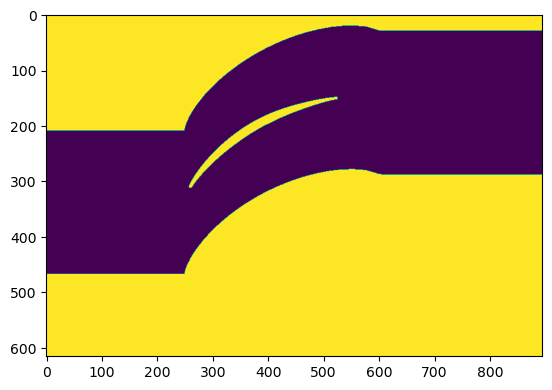

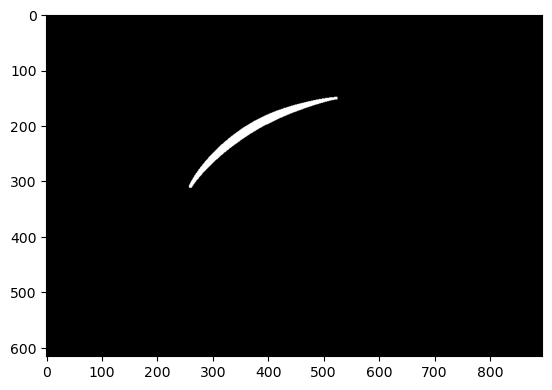

机翼最左下坐标：(258, 312)
leftmost_x,rightmost_x,bottommost_point,topmost_point: 257 525 (521, 148) (258, 312)
x0,y0 257 312
中线最左坐标：(257, 315)
airfoil_coor [[495, 433], [477, 439], [462, 440], [447, 440], [432, 439], [418, 437], [404, 435], [391, 431], [378, 427], [366, 422], [353, 417], [341, 410], [330, 404], [319, 396], [308, 388], [298, 379], [288, 369], [278, 358], [269, 345], [265, 338], [262, 331], [258, 323], [257, 318], [257, 316], [257, 315]]
line_mask.shape (616, 895)


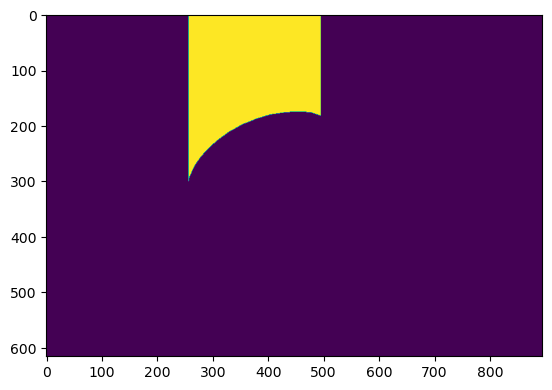

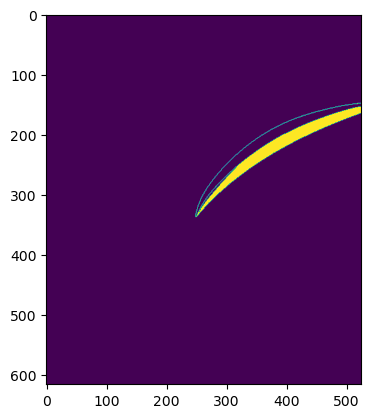

above_mask.shape, dark_blue_mask.shape (616, 525) (616, 525)


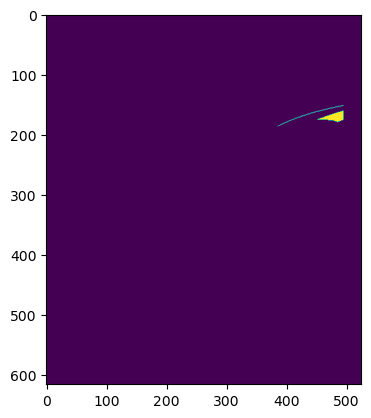

5201

In [29]:
image4 = cv2.imread("/kaggle/input/flowfieldpic/Pic/case1-100.png")

capture_airfoil("/kaggle/input/flowfieldpic/Pic/case411-175.png")

In [ ]:
import os
import glob

# 指定文件夹路径
pic_path = glob.glob("/kaggle/input/flowfieldpic/Pic/*")

df = pd.DataFrame(columns=["图片名", '失速面积','失速开始位置'])

# 遍历文件夹中的所有文件
for file_path in pic_path:
    area=capture_airfoil(file_path)
    # 迭代添加行数据
    data = {'图片名': file_name,
            '失速面积': area,
           '失速开始位置':start_coor}
    df.loc[len(df)] = data
    # 保存到Excel文件
    df.to_excel('分类结果.xlsx', index=False)
    